In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import numpy as np

from scipy.stats import pearsonr, spearmanr

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from helper_functions import coef_det_k, fixed_scale, ARGUMENTS, label_maker_9000

os.environ["CUDA_VISIBLE_DEVICES"]="0"

2023-06-16 16:42:35.757840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
embedings_file = "../results/Embeddings/embedings_all_tms_nonredun_780.pkl"
with open(embedings_file, "rb") as f:
    df = pickle.load(f)

# Reformat data frame as hashmap with keys as id
data_df = {}
for id_, EMB, TM in zip(df["id"], df["Embedding"], df["TM"]):
    data_df[id_] = [EMB, TM]

In [22]:
## Split data into train val test

df_all_30   = pd.read_csv("../data/clu_30_cluster.tsv", sep="\t", header=None, names=["clusters", "sequences"])
#df_all_30.columns = ["clusters", "sequence"]
df_train_30 = pd.read_csv("../data/train_clusters.tsv", sep="\t", header=None, names=["clusters"])
df_val_30   = pd.read_csv("../data/val_clusters.tsv", sep="\t", header=None, names=["clusters"])
df_test_30  = pd.read_csv("../data/test_clusters.tsv", sep="\t", header=None, names=["clusters"])

df_train_30 = df_train_30.merge(df_all_30, on = "clusters", how = "left")
df_val_30   = df_val_30.merge(df_all_30, on = "clusters", how = "left")
df_test_30  = df_test_30.merge(df_all_30, on = "clusters", how = "left")


training_data = df_train_30["sequences"].apply(lambda x: data_df[x])
val_data      = df_val_30["sequences"].apply(lambda x: data_df[x])
test_data     = df_test_30["sequences"].apply(lambda x: data_df[x])

df_train_30["Embedding"], df_train_30["TM"] = zip(*[(eli[0], eli[1]) for eli in training_data])
df_val_30["Embedding"], df_val_30["TM"]     = zip(*[(eli[0], eli[1]) for eli in val_data])
df_test_30["Embedding"], df_test_30["TM"]   = zip(*[(eli[0], eli[1]) for eli in test_data])

df_train_30["class"] = df_train_30.apply(lambda x: label_maker_9000(x["TM"], 60), axis = 1)
df_val_30["class"]   = df_val_30.apply(lambda x: label_maker_9000(x["TM"], 60), axis = 1)
df_test_30["class"]  = df_test_30.apply(lambda x: label_maker_9000(x["TM"], 60), axis = 1)

df_train_30["label"] = df_train_30.apply(lambda x: "Training set", axis = 1)
df_val_30["label"]   = df_val_30.apply(lambda x: "validation set", axis = 1)
df_test_30["label"]  = df_test_30.apply(lambda x: "Testing set", axis = 1)

x_train = np.array(df_train_30["Embedding"].to_list())
y_train = np.array(df_train_30["TM"])
y_train_c = np.array(df_train_30["class"])

x_val   = np.array(df_val_30["Embedding"].to_list())
y_val   = np.array(df_val_30["TM"])
y_val_c = np.array(df_val_30["class"])

x_test = np.array(df_test_30["Embedding"].to_list())
y_test = np.array(df_test_30["TM"])
y_test_c = np.array(df_test_30["class"])

print(f"Training set contains {y_train.size} samples")
print(f"Validation set contains {y_val.size} samples")
print(f"Test set contains {y_test.size} samples")

# One dataframe to rule them all 
df_all = pd.concat([df_train_30, df_val_30, df_test_30])

Training set contains 27568 samples
Validation set contains 3000 samples
Test set contains 3000 samples


/tmp/ipykernel_3129/452974427.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x= y_train, palette="light:g", bins = 30, ax = ax, stat = "probability", kde = True)
/tmp/ipykernel_3129/452974427.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x= y_val, palette="light:g", bins = 30, ax = ax, stat = "probability", kde = True)
/tmp/ipykernel_3129/452974427.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x= y_test, palette="light:g", bins = 30, ax = ax, stat = "probability", kde = True)


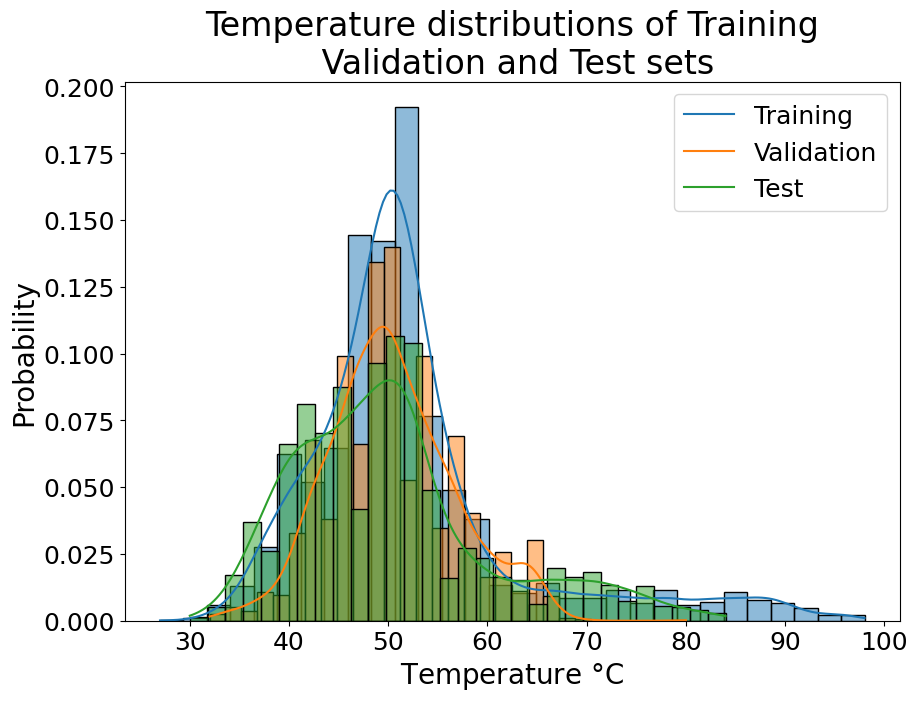

In [23]:
f, ax = plt.subplots(1, figsize=[10,7])
#sns.histplot(data = df_all, x= "TM", hue = "label", bins = 30, ax = ax, stat = "density",multiple="dodge" , kde = True)
sns.histplot(x= y_train, palette="light:g", bins = 30, ax = ax, stat = "probability", kde = True)
sns.histplot(x= y_val, palette="light:g", bins = 30, ax = ax, stat = "probability", kde = True)
sns.histplot(x= y_test, palette="light:g", bins = 30, ax = ax, stat = "probability", kde = True)
plt.title("Temperature distributions of Training\n Validation and Test sets")
plt.legend(["Training", "Validation", "Test"])
ax.set_xlabel(r"Temperature $\degree$C")
plt.savefig("../results/img/temperature_distributions.jpeg")
plt.show()

[0.14183725 0.03853203]
[1525.4662  795.0938]


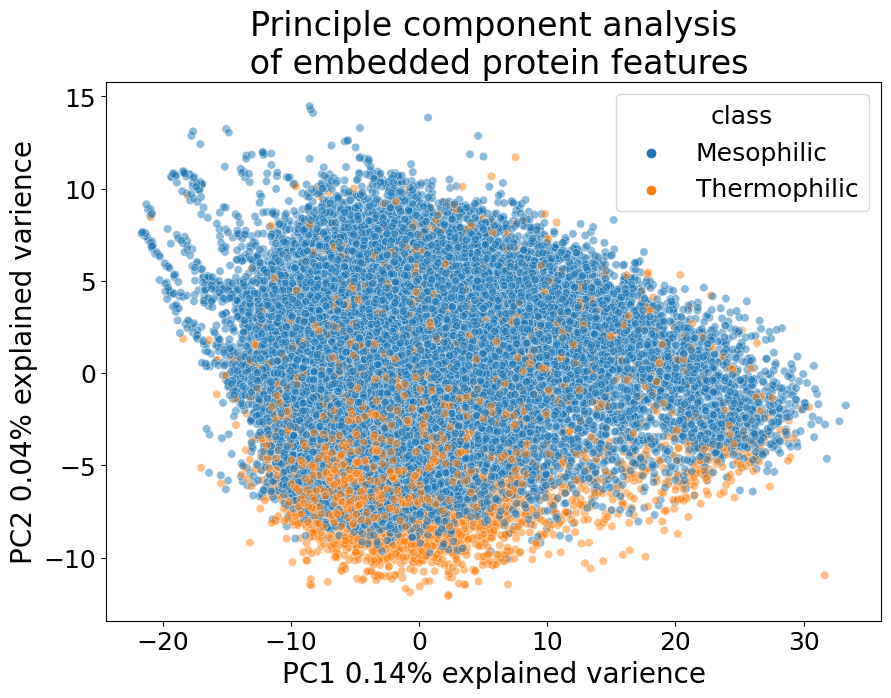

In [24]:
X = np.array(df_all["Embedding"].to_list())
pca = PCA(n_components=2)
pca.fit(X)
PCA(n_components=2)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
df_all["PC1"], df_all["PC2"] = zip(*pca.transform(X))


f, ax = plt.subplots(1, figsize=[10,7])
sns.scatterplot(data = df_all, x = "PC1", y = "PC2", hue = "class", ax = ax, alpha = 0.5)
plt.title("Principle component analysis\n of embedded protein features")
plt.xlabel(f"PC1 {pca.explained_variance_ratio_[0]:.2f}% explained varience")
plt.ylabel(f"PC2 {pca.explained_variance_ratio_[1]:.2f}% explained varience")
#plt.legend([r"TM < 60 $\degree$ C", r"TM >= 60 $\degree$ C"])
plt.savefig("../results/img/embeddings_pca.jpeg")

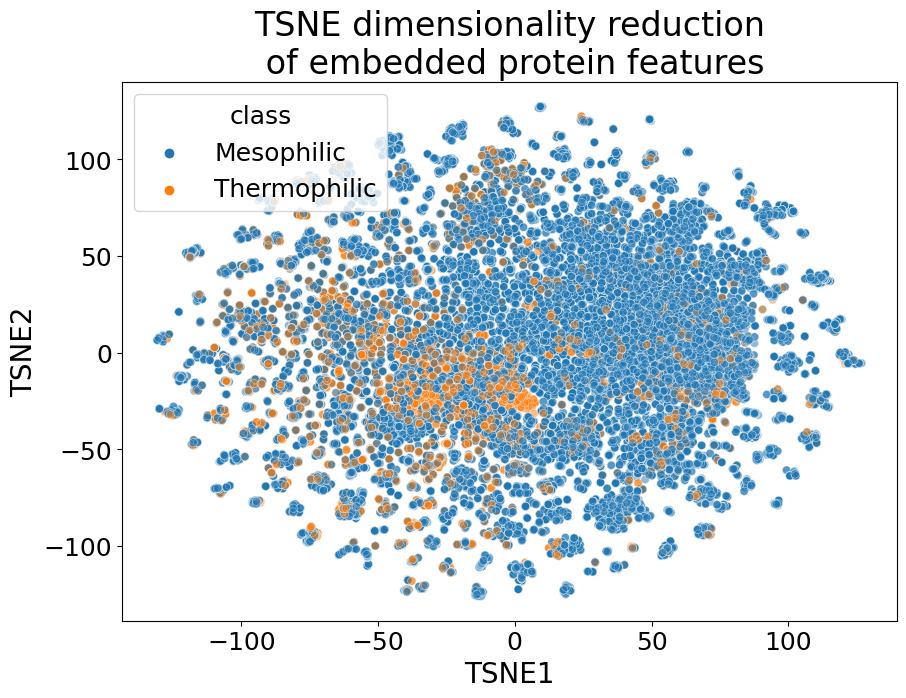

In [25]:
df_all["TSNE1"], df_all["TSNE2"] = zip(*TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(X))
f, ax = plt.subplots(1, figsize=[10,7])
sns.scatterplot(data = df_all, x = "TSNE1", y = "TSNE2", hue = "class", alpha = 0.5)
plt.title("TSNE dimensionality reduction\n of embedded protein features")
plt.savefig("../results/img/embeddings_tsne.jpeg")

In [ ]:
## Base line from classical method

In [27]:


# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(x_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

R square 0.22553829006679083  
MSE 78.35995698805029
Median absolute error 5.414619130185351
Explained varience 0.23634631116883698
Pearson correlation 0.5014029578215802
Spearman correlation 0.46840723545087026


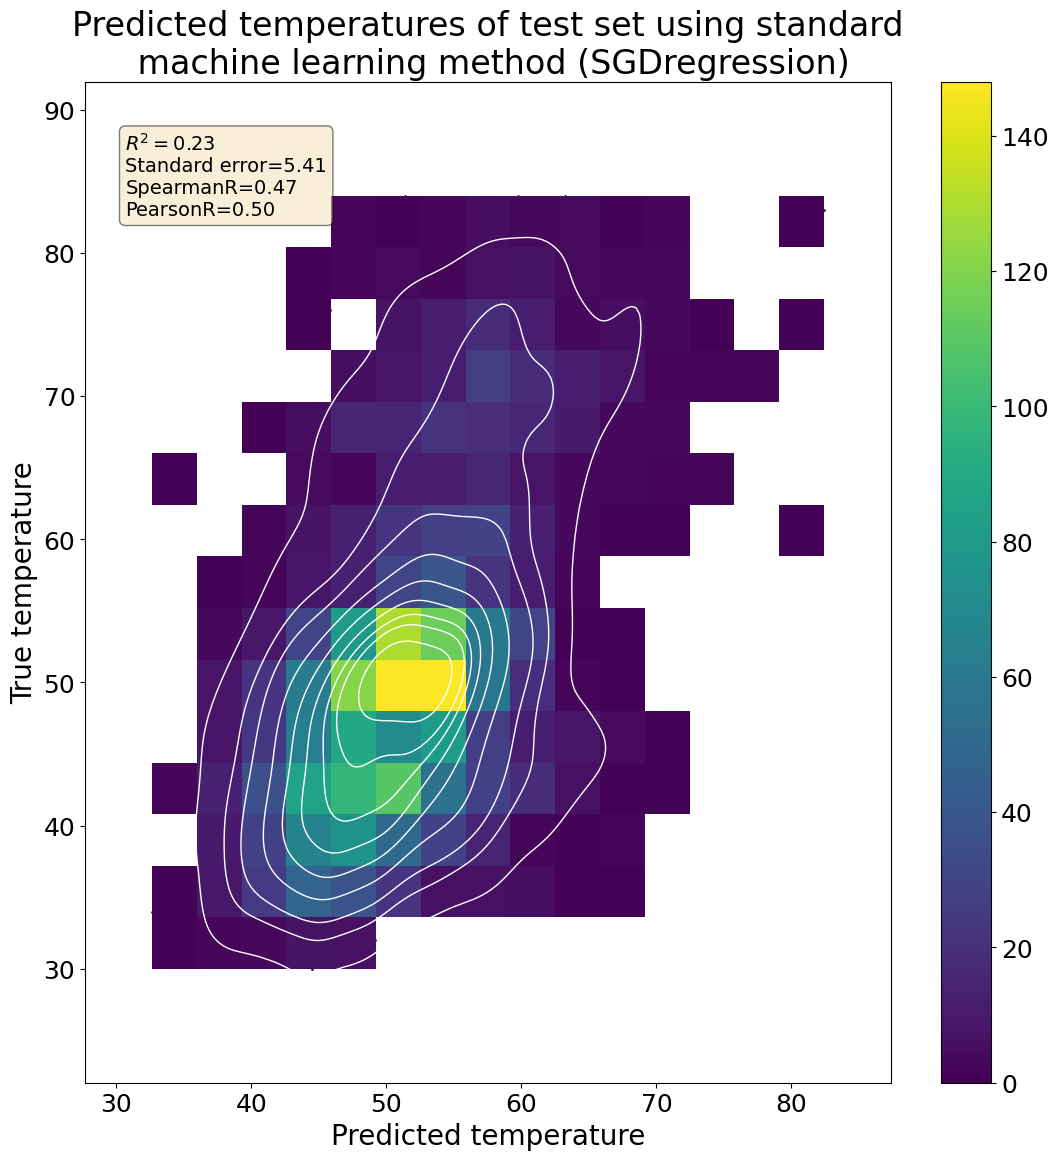

In [29]:




x = reg.predict(x_test)



f, ax = plt.subplots(figsize=[13, 13])
sns.scatterplot(x=x, y=y_test, s=5, color=".15")

sns.histplot(x=x, y=y_test, bins=15,cmap="viridis", cbar = True, pmax = 0.9)
sns.kdeplot(x=x, y=y_test, levels=10, color="w", linewidths=1)
#plt.xlim([2,103])
#plt.ylim([2, 103])
plt.title("Predicted temperatures of test set using standard\n machine learning method (SGDregression)")
plt.xlabel("Predicted temperature")
plt.ylabel("True temperature")

r = sklearn.metrics.r2_score(y_test, x)
e = sklearn.metrics.explained_variance_score(y_test, x)
mse = sklearn.metrics.mean_squared_error(y_test, x)
mdi = sklearn.metrics.median_absolute_error(y_test, x)

corr_p, _ = pearsonr(y_test, x)
corr_s, _ = spearmanr(y_test, x)
print("R square {}  ".format(r))
print("MSE {}".format(mse))
print("Median absolute error {}".format(mdi))
print("Explained varience {}".format(e))
print("Pearson correlation {}".format(corr_p))
print("Spearman correlation {}".format(corr_s))

textstr = '\n'.join((
    r'$R^2=%.2f$' % (r, ),
    r'Standard error=%.2f' % (mdi, ),
    r'SpearmanR=%.2f' % (corr_s, ),
    r'PearsonR=%.2f' % (corr_p, )))


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig("../results/img/classical_baseline.png")



In [32]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512,input_shape=(1280,), activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation = "linear"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                      

In [24]:
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#              loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

model_up.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError(), metrics=[coef_det_k])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.00001)
estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,start_from_epoch=50, restore_best_weights=True)
model_no_scale = "../results/Models/No_Scale/"
chkp = tf.keras.callbacks.ModelCheckpoint(
    model_no_scale,
    monitor = 'val_loss',
    save_best_only = True)

In [25]:
history = model.fit(x = x_train, y = y_train, batch_size = 64, validation_split=0.1, epochs=100, callbacks=[reduce_lr, estop, chkp]) 

Epoch 1/100


2023-06-16 15:43:21.298437: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x32aae150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-16 15:43:21.298495: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro GP100, Compute Capability 6.0
2023-06-16 15:43:21.313631: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-16 15:43:21.520926: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


388/388 [==============================] - 8s 14ms/step - loss: 377.8005 - coef_det_k: -2.3500 - val_loss: 70.0975 - val_coef_det_k: -1.0112 - lr: 0.0010
Epoch 2/100
388/388 [==============================] - 4s 10ms/step - loss: 73.5735 - coef_det_k: 0.3550 - val_loss: 70.4879 - val_coef_det_k: -1.0596 - lr: 0.0010
Epoch 3/100
388/388 [==============================] - 5s 12ms/step - loss: 64.6757 - coef_det_k: 0.4281 - val_loss: 65.5015 - val_coef_det_k: -0.8595 - lr: 0.0010
Epoch 4/100
388/388 [==============================] - 5s 13ms/step - loss: 60.9217 - coef_det_k: 0.4673 - val_loss: 61.1910 - val_coef_det_k: -0.6794 - lr: 0.0010
Epoch 5/100
388/388 [==============================] - 4s 9ms/step - loss: 57.5536 - coef_det_k: 0.4994 - val_loss: 64.4537 - val_coef_det_k: -0.8138 - lr: 0.0010
Epoch 6/100
388/388 [==============================] - 4s 10ms/step - loss: 54.5702 - coef_det_k: 0.5160 - val_loss: 67.6901 - val_coef_det_k: -0.9258 - lr: 0.0010
Epoch 7/100
388/388 [======

94/94 [==============================] - 0s 2ms/step
R square 0.3757053509496343  
MSE 63.16606905159394
Median absolute error 3.701740264892578
Explained varience 0.3765071497165027
Pearson correlation 0.6317530045837414
Spearman correlation 0.6351978961198714


Text(0.05, 0.95, '$R^2=0.38$\nStandard error=3.70\nSpearmanR=0.64\nPearsonR=0.63')

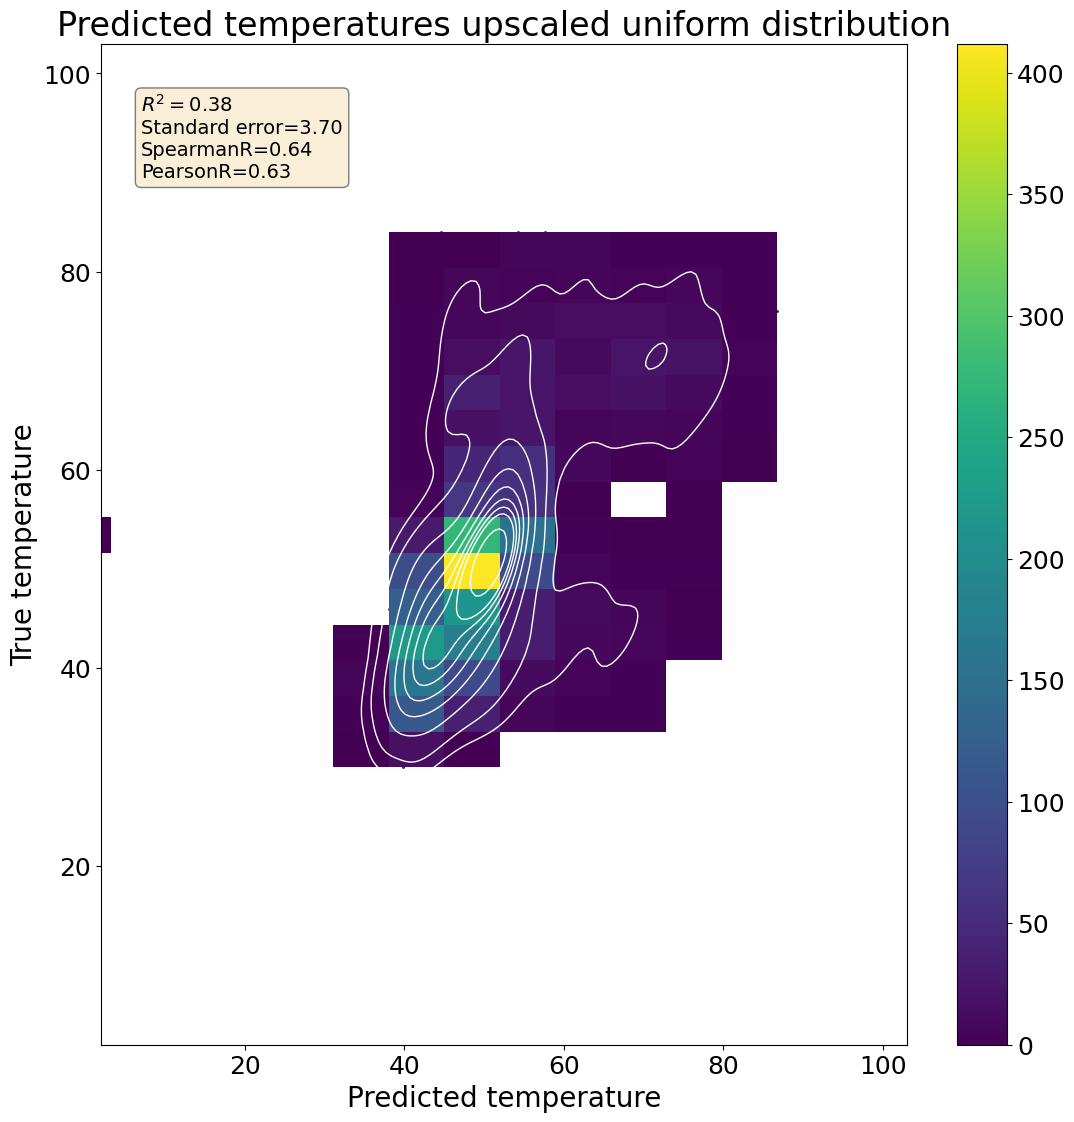

In [31]:
model_no_scale = "../results/Models/No_Scale/"
model = tf.keras.models.load_model(
    model_no_scale, custom_objects={"coef_det_k":coef_det_k}, compile=True, options=None)
x = model.predict(x_test)

x = x.reshape((x.shape[0]))

f, ax = plt.subplots(figsize=[13, 13])
sns.scatterplot(x=x, y=y_test, s=5, color=".15")

sns.histplot(x=x, y=y_test, bins=15,cmap="viridis", cbar = True, pmax = 0.9)
sns.kdeplot(x=x, y=y_test, levels=10, color="w", linewidths=1)
plt.xlim([2,103])
plt.ylim([2, 103])
plt.title("Predicted temperatures upscaled uniform distribution")
plt.xlabel("Predicted temperature")
plt.ylabel("True temperature")

r = sklearn.metrics.r2_score(y_test, x)
e = sklearn.metrics.explained_variance_score(y_test, x)
mse = sklearn.metrics.mean_squared_error(y_test, x)
mdi = sklearn.metrics.median_absolute_error(y_test, x)

corr_p, _ = pearsonr(y_test, x)
corr_s, _ = spearmanr(y_test, x)
print("R square {}  ".format(r))
print("MSE {}".format(mse))
print("Median absolute error {}".format(mdi))
print("Explained varience {}".format(e))
print("Pearson correlation {}".format(corr_p))
print("Spearman correlation {}".format(corr_s))

textstr = '\n'.join((
    r'$R^2=%.2f$' % (r, ),
    r'Standard error=%.2f' % (mdi, ),
    r'SpearmanR=%.2f' % (corr_s, ),
    r'PearsonR=%.2f' % (corr_p, )))


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#plt.savefig("img_reg_upscale.png")



TM
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]
no sequences at temperature range [28, 29]


/tmp/ipykernel_3129/172253866.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_scaled, bins = 71, x= "TM", palette="light:g")


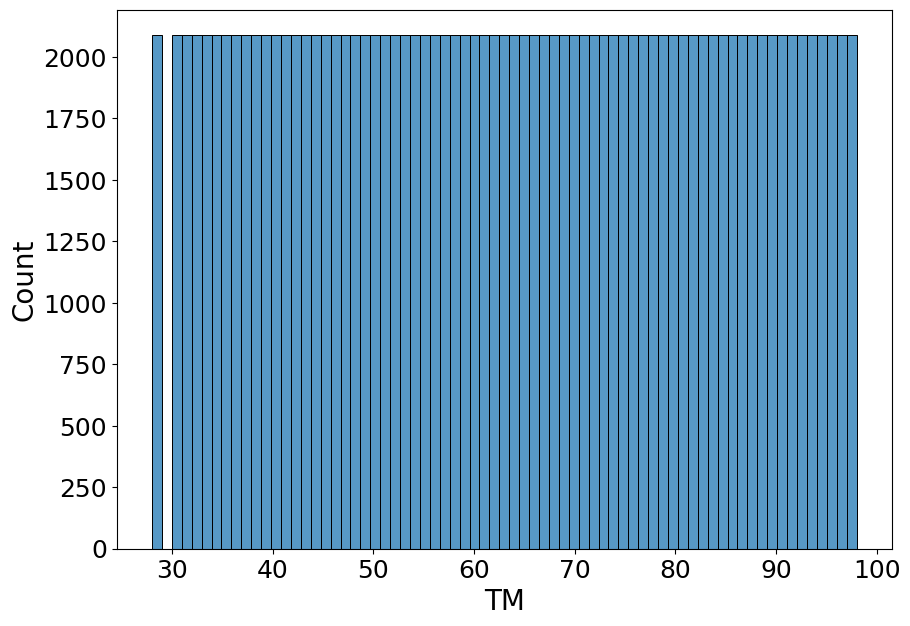

In [11]:

df_train_30.groupby("TM")

max_counts = int(df_train_30.groupby("TM").size().reset_index(name ="counts").max()["counts"])

args = ARGUMENTS(ranges = [0] , enumerate = 1, fixed_scale = max_counts, name = "TM")
df_scaled = fixed_scale(args, df_train_30, use_min=False)

plt.figure(figsize=[10,7])
sns.histplot(data=df_scaled, bins = 71, x= "TM", palette="light:g")
plt.show()


In [14]:
x_train = np.array(df_scaled["Embedding"].to_list())
y_train = np.array(df_scaled["TM"])

model_up = tf.keras.Sequential()
model_up.add(tf.keras.layers.Dense(512,input_shape=(1280,), activation="relu"))
model_up.add(tf.keras.layers.Dropout(0.4))
model_up.add(tf.keras.layers.BatchNormalization())
model_up.add(tf.keras.layers.Dense(512, activation="relu"))
model_up.add(tf.keras.layers.Dropout(0.4))
model_up.add(tf.keras.layers.BatchNormalization())
model_up.add(tf.keras.layers.Dense(256, activation="relu"))
model_up.add(tf.keras.layers.Dropout(0.3))
model_up.add(tf.keras.layers.Dense(1, activation = "linear"))
model_up.summary()

model_up.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError(), metrics=[coef_det_k])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.00001)
estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,start_from_epoch=20, restore_best_weights=True)
model_up_scale = "../results/Models/up_Scale/"
chkp = tf.keras.callbacks.ModelCheckpoint(
    model_up_scale,
    monitor = 'val_loss',
    save_best_only = True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               655872    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 512)              2048      
 hNormalization)                                      

In [15]:
history_up = model_up.fit(x = x_train, y = y_train, batch_size = 64, validation_data = (x_val, y_val), epochs=100, callbacks=[reduce_lr, estop, chkp]) 

Epoch 1/100
2283/2283 [==============================] - 25s 10ms/step - loss: 161.6638 - coef_det_k: 0.5924 - val_loss: 102.8112 - val_coef_det_k: -2.0519 - lr: 0.0010
Epoch 2/100
2283/2283 [==============================] - 23s 10ms/step - loss: 68.3436 - coef_det_k: 0.8276 - val_loss: 100.1296 - val_coef_det_k: -1.9604 - lr: 0.0010
Epoch 3/100
2283/2283 [==============================] - 22s 10ms/step - loss: 58.5666 - coef_det_k: 0.8522 - val_loss: 103.7288 - val_coef_det_k: -2.0948 - lr: 0.0010
Epoch 4/100
2283/2283 [==============================] - 22s 9ms/step - loss: 52.5897 - coef_det_k: 0.8674 - val_loss: 134.8448 - val_coef_det_k: -2.7104 - lr: 0.0010
Epoch 5/100
2283/2283 [==============================] - 22s 10ms/step - loss: 49.1409 - coef_det_k: 0.8759 - val_loss: 107.5929 - val_coef_det_k: -2.1439 - lr: 0.0010
Epoch 6/100
2283/2283 [==============================] - 22s 10ms/step - loss: 46.3028 - coef_det_k: 0.8834 - val_loss: 2715.4194 - val_coef_det_k: -77.2947 - l

94/94 [==============================] - 0s 2ms/step
R square -15.813772486257474  
MSE 1701.2157888911313
Median absolute error 4.130346298217773
Explained varience -15.813325253603786
Pearson correlation 0.1399915388442361
Spearman correlation 0.6134112361292604


Text(0.05, 0.95, '$R^2=-15.81$\nStandard error=4.13\nSpearmanR=0.61\nPearsonR=0.14')

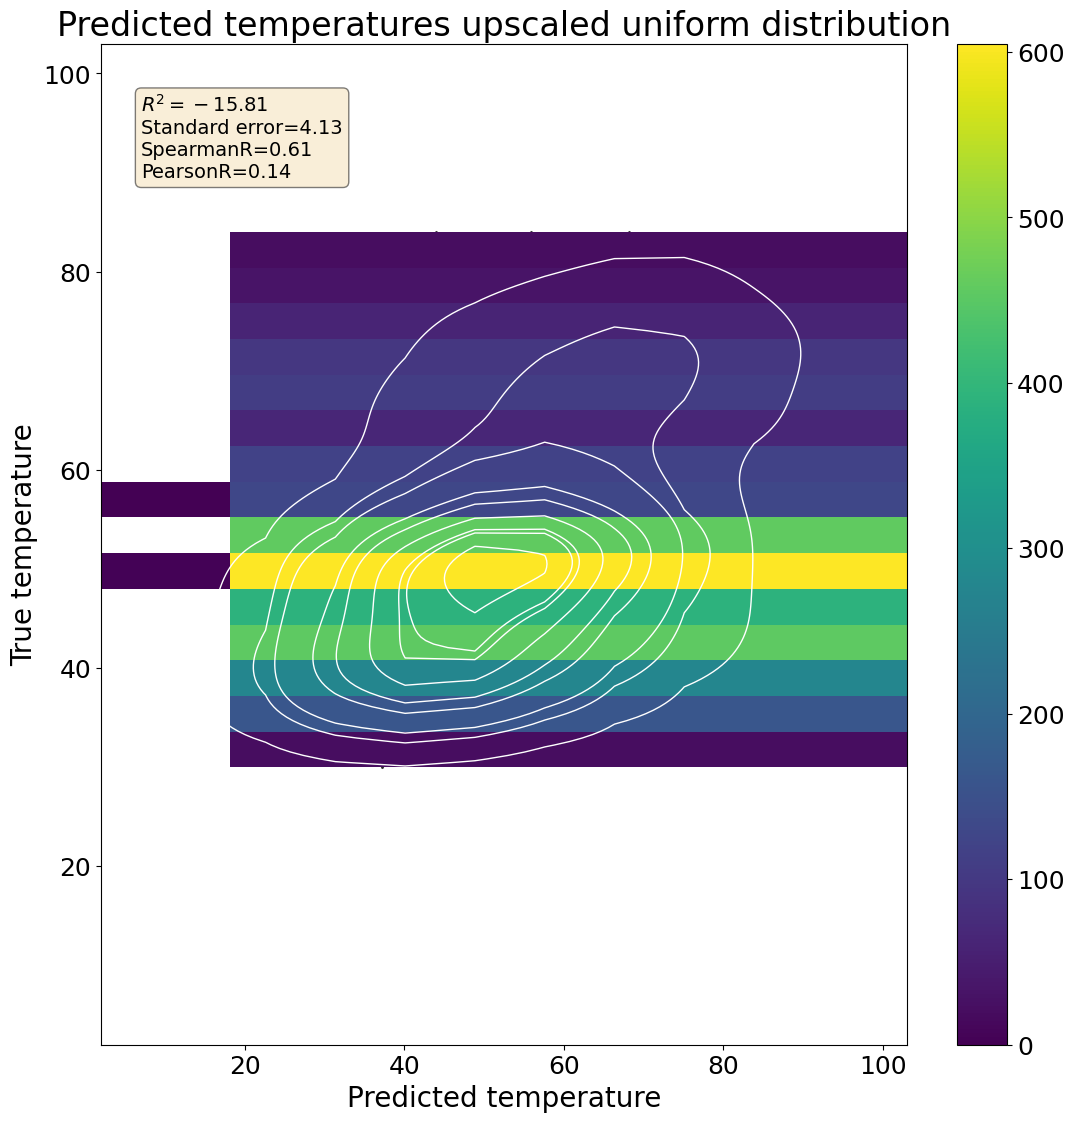

In [16]:
x = model_up.predict(x_test)

x = x.reshape((x.shape[0]))

f, ax = plt.subplots(figsize=[13, 13])
sns.scatterplot(x=x, y=y_test, s=5, color=".15")

sns.histplot(x=x, y=y_test, bins=15,cmap="viridis", cbar = True, pmax = 0.9)
sns.kdeplot(x=x, y=y_test, levels=10, color="w", linewidths=1)
plt.xlim([2,103])
plt.ylim([2, 103])
plt.title("Predicted temperatures upscaled uniform distribution")
plt.xlabel("Predicted temperature")
plt.ylabel("True temperature")

r = sklearn.metrics.r2_score(y_test, x)
e = sklearn.metrics.explained_variance_score(y_test, x)
mse = sklearn.metrics.mean_squared_error(y_test, x)
mdi = sklearn.metrics.median_absolute_error(y_test, x)

corr_p, _ = pearsonr(y_test, x)
corr_s, _ = spearmanr(y_test, x)
print("R square {}  ".format(r))
print("MSE {}".format(mse))
print("Median absolute error {}".format(mdi))
print("Explained varience {}".format(e))
print("Pearson correlation {}".format(corr_p))
print("Spearman correlation {}".format(corr_s))

textstr = '\n'.join((
    r'$R^2=%.2f$' % (r, ),
    r'Standard error=%.2f' % (mdi, ),
    r'SpearmanR=%.2f' % (corr_s, ),
    r'PearsonR=%.2f' % (corr_p, )))


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#plt.savefig("img_reg_upscale.png")



TM
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]
no sequences at temperature range [28, 29]


/tmp/ipykernel_3129/45102866.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_scaled, bins = 71, x= "TM", palette="light:g")


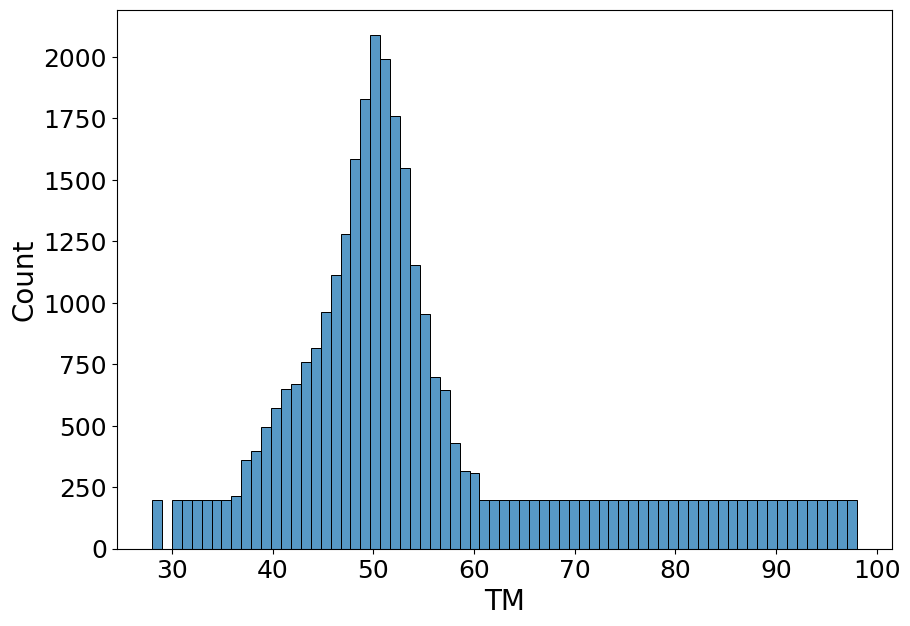

In [17]:
df_train_30.groupby("TM")



args = ARGUMENTS(ranges = [0] , enumerate = 1, fixed_scale = 200, name = "TM")
df_scaled = fixed_scale(args, df_train_30, use_min=True)

plt.figure(figsize=[10,7])
sns.histplot(data=df_scaled, bins = 71, x= "TM", palette="light:g")
plt.show()


In [18]:
x_train = np.array(df_scaled["Embedding"].to_list())
y_train = np.array(df_scaled["TM"])

model_up_200 = tf.keras.Sequential()
model_up_200.add(tf.keras.layers.Dense(512,input_shape=(1280,), activation="relu"))
model_up_200.add(tf.keras.layers.Dropout(0.4))
model_up_200.add(tf.keras.layers.BatchNormalization())
model_up_200.add(tf.keras.layers.Dense(512, activation="relu"))
model_up_200.add(tf.keras.layers.Dropout(0.4))
model_up_200.add(tf.keras.layers.BatchNormalization())
model_up_200.add(tf.keras.layers.Dense(256, activation="relu"))
model_up_200.add(tf.keras.layers.Dropout(0.3))
model_up_200.add(tf.keras.layers.Dense(1, activation = "linear"))
model_up_200.summary()

model_up_200.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError(), metrics=[coef_det_k])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.00001)
estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,start_from_epoch=20, restore_best_weights=True)
model_up_200_scale = "../results/Models/up_200_Scale/"
chkp = tf.keras.callbacks.ModelCheckpoint(
    model_up_200_scale,
    monitor = 'val_loss',
    save_best_only = True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               655872    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_7 (Batc  (None, 512)              2048      
 hNormalization)                                      

In [19]:
history_up_200 = model_up_200.fit(x = x_train, y = y_train, batch_size = 64, validation_data = (x_val, y_val), epochs=100, callbacks=[reduce_lr, estop, chkp]) 

Epoch 1/100
510/510 [==============================] - 9s 14ms/step - loss: 324.0554 - coef_det_k: -0.3774 - val_loss: 74.2014 - val_coef_det_k: -1.3160 - lr: 0.0010
Epoch 2/100
510/510 [==============================] - 5s 10ms/step - loss: 74.6425 - coef_det_k: 0.6682 - val_loss: 86.7973 - val_coef_det_k: -1.6633 - lr: 0.0010
Epoch 3/100
510/510 [==============================] - 5s 10ms/step - loss: 67.5823 - coef_det_k: 0.6987 - val_loss: 75.7881 - val_coef_det_k: -1.3837 - lr: 0.0010
Epoch 4/100
510/510 [==============================] - 5s 10ms/step - loss: 62.7961 - coef_det_k: 0.7205 - val_loss: 77.1848 - val_coef_det_k: -1.4521 - lr: 0.0010
Epoch 5/100
510/510 [==============================] - 5s 10ms/step - loss: 57.4607 - coef_det_k: 0.7478 - val_loss: 77.5309 - val_coef_det_k: -1.5207 - lr: 0.0010
Epoch 6/100
510/510 [==============================] - 5s 10ms/step - loss: 55.1147 - coef_det_k: 0.7568 - val_loss: 78.5372 - val_coef_det_k: -1.5603 - lr: 0.0010
Epoch 7/100
51

94/94 [==============================] - 0s 2ms/step
R square 0.3708884668624506  
MSE 63.65344089328343
Median absolute error 3.8367786407470703
Explained varience 0.3711102168216115
Pearson correlation 0.624969502048348
Spearman correlation 0.6182811718452225


Text(0.05, 0.95, '$R^2=0.37$\nStandard error=3.84\nSpearmanR=0.62\nPearsonR=0.62')

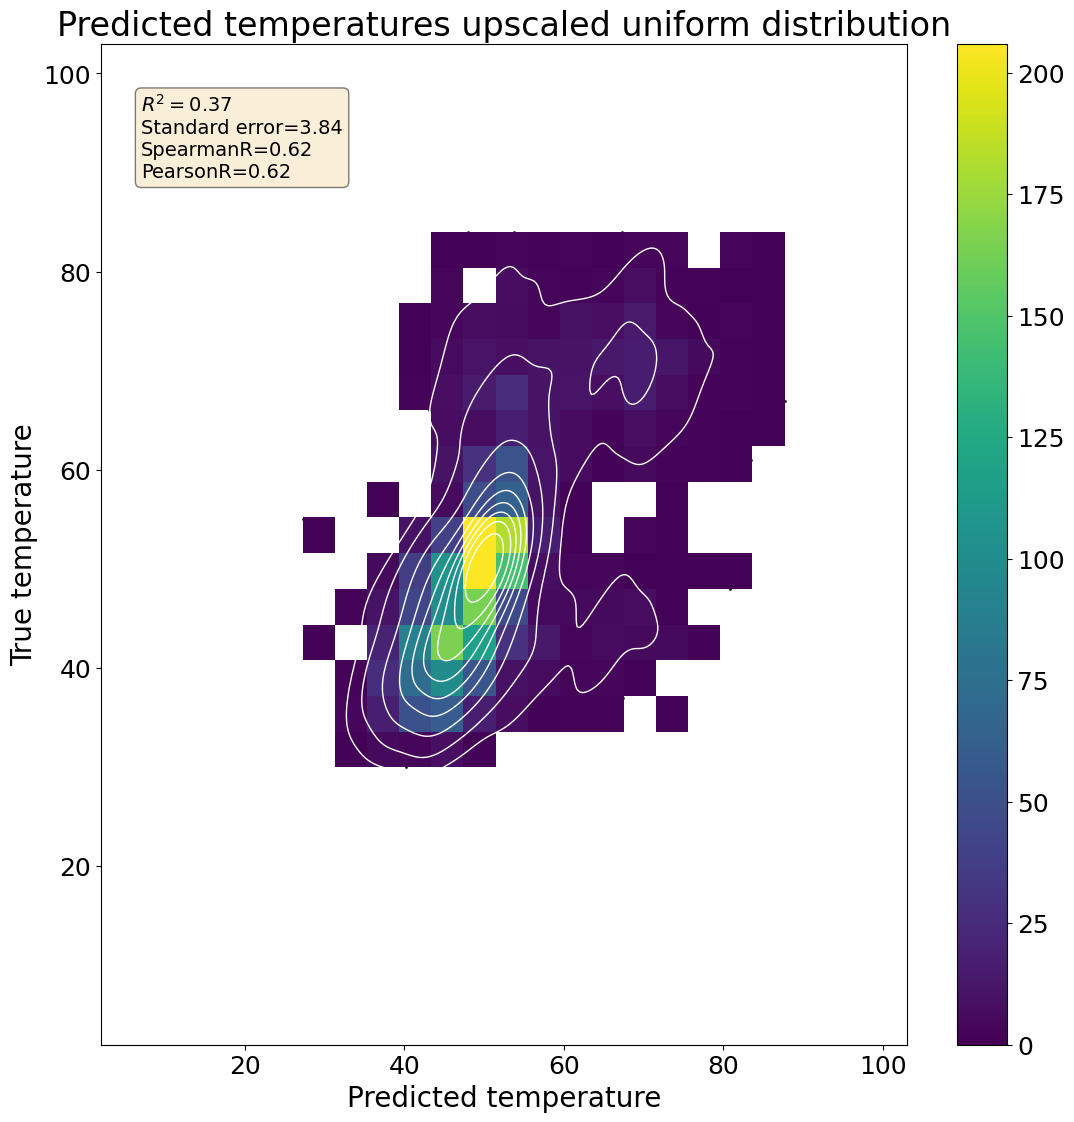

In [20]:
x = model_up_200.predict(x_test)

x = x.reshape((x.shape[0]))

f, ax = plt.subplots(figsize=[13, 13])
sns.scatterplot(x=x, y=y_test, s=5, color=".15")

sns.histplot(x=x, y=y_test, bins=15,cmap="viridis", cbar = True, pmax = 0.9)
sns.kdeplot(x=x, y=y_test, levels=10, color="w", linewidths=1)
plt.xlim([2,103])
plt.ylim([2, 103])
plt.title("Predicted temperatures upscaled uniform distribution")
plt.xlabel("Predicted temperature")
plt.ylabel("True temperature")

r = sklearn.metrics.r2_score(y_test, x)
e = sklearn.metrics.explained_variance_score(y_test, x)
mse = sklearn.metrics.mean_squared_error(y_test, x)
mdi = sklearn.metrics.median_absolute_error(y_test, x)

corr_p, _ = pearsonr(y_test, x)
corr_s, _ = spearmanr(y_test, x)
print("R square {}  ".format(r))
print("MSE {}".format(mse))
print("Median absolute error {}".format(mdi))
print("Explained varience {}".format(e))
print("Pearson correlation {}".format(corr_p))
print("Spearman correlation {}".format(corr_s))

textstr = '\n'.join((
    r'$R^2=%.2f$' % (r, ),
    r'Standard error=%.2f' % (mdi, ),
    r'SpearmanR=%.2f' % (corr_s, ),
    r'PearsonR=%.2f' % (corr_p, )))


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#plt.savefig("img_reg_upscale.png")

